# **Tech Challenge 2 - Previsão Ibovespa**

# **1. Importações**

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

## **2. Carregamento dos Dados (CSV)**

Arquivo extraído do Investing.com com dados diários do Ibovespa.

Datas extraídas:
**01.01.2020 - 01.12.2025**

In [106]:
path = "data/dados_ibovespa.csv"

df = pd.read_csv(path)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.09.2025,141.283,141.423,141.950,140.878,"4,95B","-0,10%"
1,29.08.2025,141.422,141.049,142.379,141.000,"9,33B","0,26%"
2,28.08.2025,141.049,139.206,142.138,139.206,"9,29B","1,32%"
3,27.08.2025,139.206,137.773,139.281,137.456,"6,61B","1,04%"
4,26.08.2025,137.771,138.026,138.037,137.058,"8,45B","-0,18%"


# **3. Pré-Processamento dos Dados**

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3884 non-null   object 
 1   Último    3884 non-null   float64
 2   Abertura  3884 non-null   float64
 3   Máxima    3884 non-null   float64
 4   Mínima    3884 non-null   float64
 5   Vol.      3883 non-null   object 
 6   Var%      3884 non-null   object 
dtypes: float64(4), object(3)
memory usage: 212.5+ KB


In [108]:
# Verificando se existem valores nulos
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Foi encontrado 1 registro com Volume vazio (nulo)

In [109]:
# Removendo registro com volume vazio
df = df[~df['Vol.'].isnull()]

Tratando as Colunas Volume (Vol.) e Variação (Var%)

In [110]:
def converter_volume(vol):
    vol = str(vol).upper().strip()
    if vol.endswith('M'):
        return float(vol[:-1].replace(',', '.')) * 1_000_000
    if vol.endswith('K'):
        return float(vol[:-1].replace(',', '.')) * 1_000
    if vol.endswith('B'):
        return float(vol[:-1].replace(',', '.')) * 1_000_000_000
    return np.nan

df['Volume'] = df['Vol.'].apply(converter_volume)

for col in ['Último','Abertura','Máxima','Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

df['Var%'] = (
    df['Var%']
    .str.replace('%','')
    .str.replace(',','.')
    .astype(float) / 100
)

Tratando a coluna de Data e transformando ela em índice

In [111]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.set_index('Data', inplace=True) # Setando a coluna Data como index
df.sort_index(inplace=True) # Ordenando por Data

## **4. Análise Exploratória (EDA)**


### Série Temporal

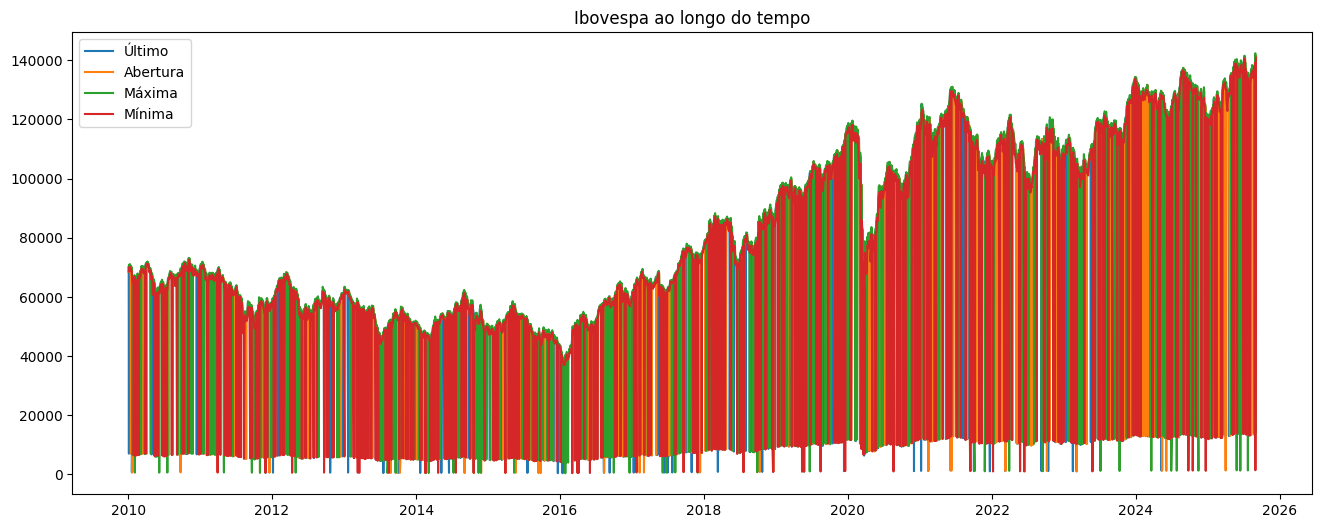

In [112]:
plt.figure(figsize=(16,6))
for col in ['Último','Abertura','Máxima','Mínima']:
    plt.plot(df.index, df[col], label=col)
plt.legend()
plt.title("Ibovespa ao longo do tempo")
plt.show()

### Distribuições

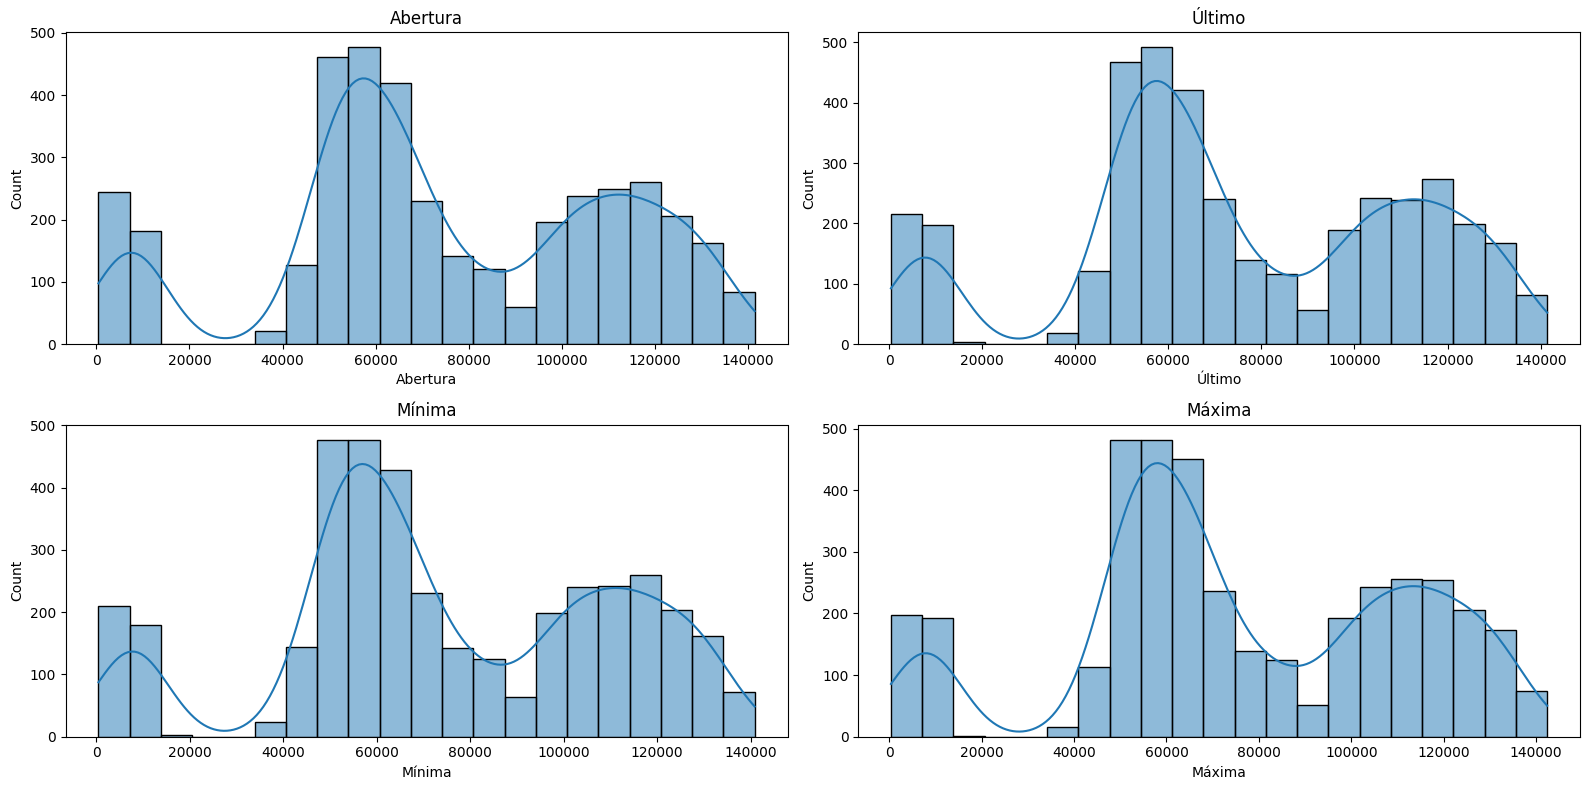

In [113]:
fig, axes = plt.subplots(2,2, figsize=(16,8))
axes = axes.flatten()

for i,col in enumerate(['Abertura','Último','Mínima','Máxima']):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### Correlação entre as Variáveis 

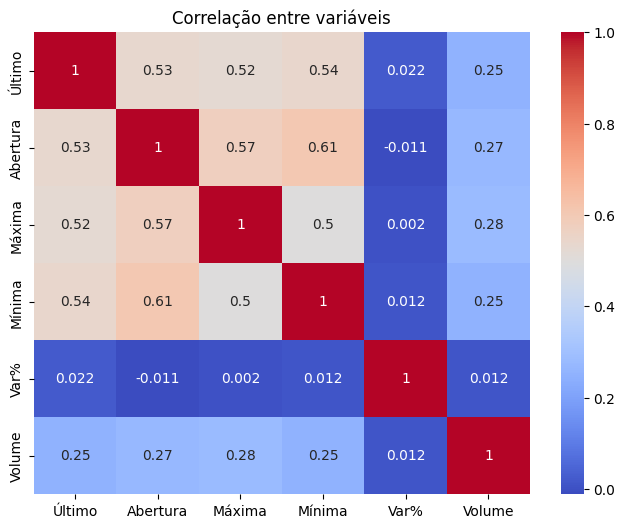

In [114]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[['Último','Abertura','Máxima','Mínima','Var%','Volume']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlação entre variáveis")
plt.show()

## **5. Feature Engeeniring**

In [115]:
df['Variação_Dia'] = df['Último'] - df['Abertura']
df['Fechamento_Anterior'] = df['Último'].shift(1)
df['Média_5_Dias'] = df['Último'].rolling(5).mean()

# Target INTELIGENTE
df['Retorno_Pct'] = df['Último'].pct_change().shift(-1)

# Sobe só se for movimento relevante
limiar = df['Retorno_Pct'].rolling(60).std()
df['Target'] = (df['Retorno_Pct'] > limiar).astype(int)

df.dropna(inplace=True)

## **6. Definindo o Target**

In [116]:
X = df[['Variação_Dia','Fechamento_Anterior','Média_5_Dias']]
y = df['Target']


## **7. Definindo Base de Teste**

Split temporal = Últimos 30 dias

In [117]:
X_train = X[:-30]
y_train = y[:-30]

X_test = X[-30:]
y_test = y[-30:]

Padronizando

In [118]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Modelos**

Os Modelos escolhidos para avaliação são:
- Baseline — Naive
- Seasonal Naive
- XGBoost
- AutoArima
- Prophet

### **Random Forest**

In [119]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

acc_rf = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {acc_rf:.2%}")

Random Forest Accuracy: 96.67%


### **Gaussian Naive Bayes**

In [120]:
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

gnb_pred = gnb.predict(X_test_scaled)
acc_gnb = accuracy_score(y_test, gnb_pred)

print(f"Gaussian Naive Bayes Accuracy: {acc_gnb:.2%}")

Gaussian Naive Bayes Accuracy: 96.67%


### **KNN**

In [121]:
knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance',
    metric='euclidean'
)

knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, knn_pred)

print(f"KNN Accuracy: {acc_knn:.2%}")

KNN Accuracy: 96.67%


### **XGBoost**

In [122]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, xgb_pred)

print(f"XGBoost Accuracy: {acc_xgb:.2%}")

XGBoost Accuracy: 96.67%


### **Prophet**

In [123]:
prophet_df = df.reset_index()[['Data','Último']]
prophet_df.columns = ['ds','y']

prophet_train = prophet_df.iloc[:-30]
prophet_test = prophet_df.iloc[-30:]

model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_train)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

prophet_pred = (
    forecast.tail(30)['yhat'].values >
    prophet_train['y'].iloc[-30:].values
).astype(int)

acc_prophet = accuracy_score(y_test, prophet_pred)

print(f"Prophet Accuracy: {acc_xgb:.2%}")

22:46:06 - cmdstanpy - INFO - Chain [1] start processing
22:46:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet Accuracy: 96.67%


## **Comparação Final**

In [124]:
resultados = pd.DataFrame({
    'Modelo': ['RandomForest','NaiveBayes','KNN','XGBoost', 'Prophet'],
    'Acurácia': [acc_rf, acc_gnb, acc_knn, acc_xgb, acc_prophet]
})

print(resultados.sort_values('Acurácia', ascending=False))

         Modelo  Acurácia
0  RandomForest  0.966667
1    NaiveBayes  0.966667
2           KNN  0.966667
3       XGBoost  0.966667
4       Prophet  0.866667


### **Melhor Modelo**

In [125]:
best_model = resultados.iloc[0]['Modelo']
print(f"Melhor modelo: {best_model}")

print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

Melhor modelo: RandomForest
[[29  1]
 [ 0  0]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.00      0.00      0.00         0

    accuracy                           0.97        30
   macro avg       0.50      0.48      0.49        30
weighted avg       1.00      0.97      0.98        30



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
